In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 16)
!date

%load_ext autoreload
%autoreload 2

Thu Mar 19 22:14:44 PDT 2020


# Supplementary Appendix Calcs for Census DP E2E Paper

We begin with the precise counts from the 1940 census at the most detailed level of stratification (counts for each enumeration district/age-group/race/ethnicity) and produce DP versions of these counts by adding variation drawn independently at random from a symmetric geometric distribution with parameter ϵ=0.00625 (chosen to match the value of ϵ used for the detailed queries in the end-to-end test of TopDown)

In [2]:
import dp_2020_census.data, dp_2020_census.model

In [3]:
df_orig = dp_2020_census.data.load_orig_counts()

In [4]:
cnt_orig = df_orig[(df_orig.state == 53)].groupby(['state', 'county', 'enum_dist'])['count'].sum()
cnt_orig

state  county  enum_dist
53     10      10            348
               20            227
               30             79
               40            121
               50            181
                            ... 
       770     1330         1642
               1340         1157
               1350         1378
               1360          145
               1370          415
Name: count, Length: 2663, dtype: int64

In [5]:
# set randoms seed for reproducibility
np.random.seed(12345)

In [6]:
epsilon = 0.25
cnt_gdpc = dp_2020_census.model.GDPC(float(epsilon)/2, cnt_orig)
cnt_gdpc

state  county  enum_dist
53     10      10            356
               20            225
               30             56
               40            122
               50            185
                            ... 
       770     1330         1651
               1340         1153
               1350         1375
               1360          146
               1370          401
Name: count, Length: 2663, dtype: int64

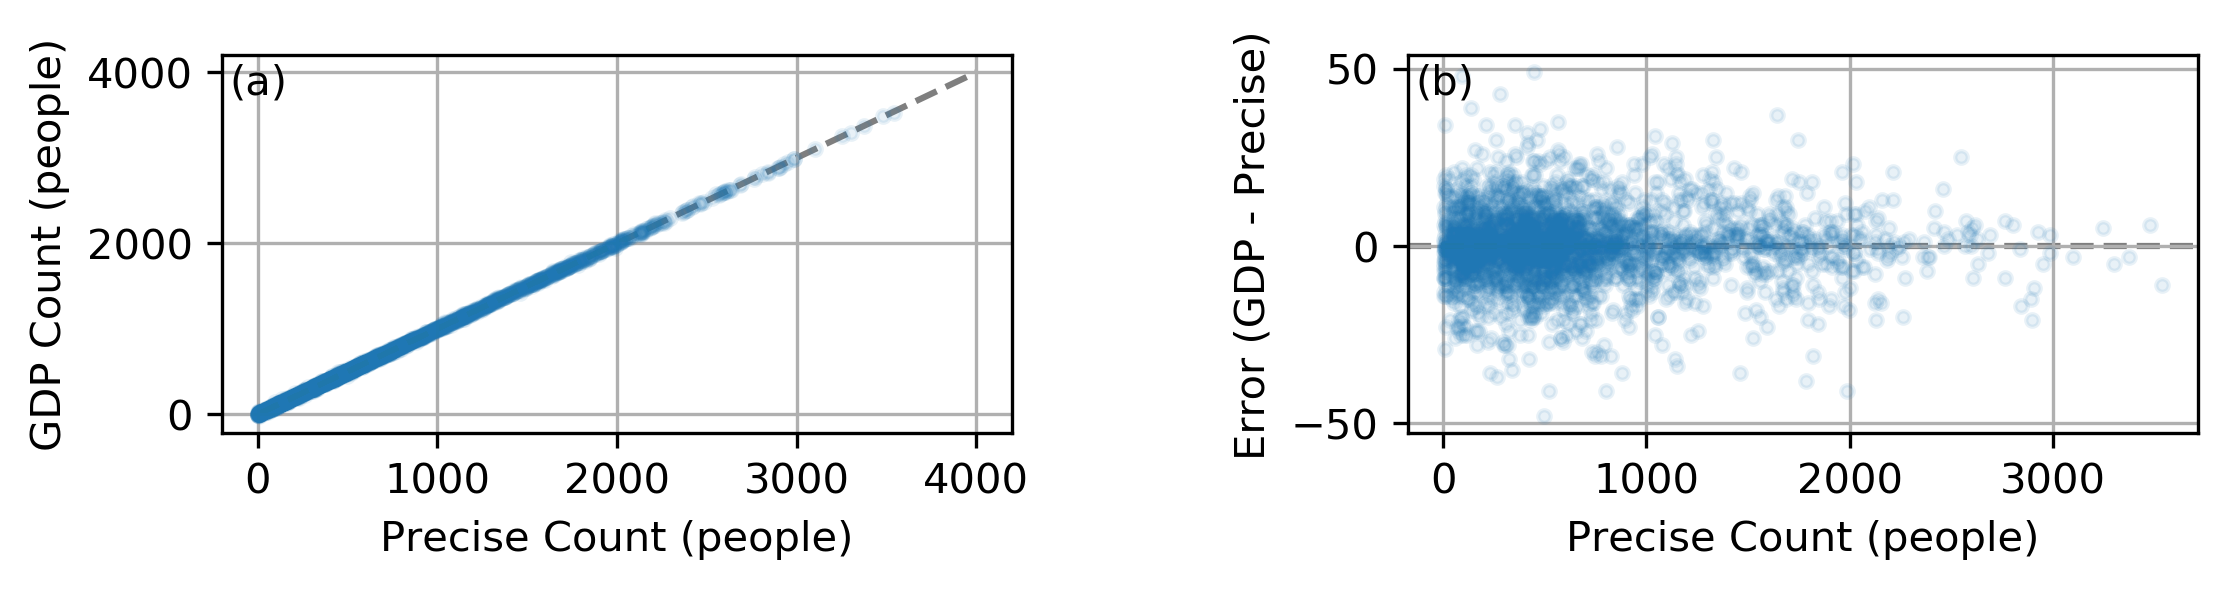

In [7]:
def my_plot(cnt_orig, cnt_gdpc):
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    ax[0].plot(cnt_orig.values, cnt_gdpc.values, '.', alpha=.1)
    ax[0].plot([0, 4_000], [0, 4_000], 'k', alpha=.5, linestyle='--', zorder=-1, )
    ax[0].set_ylabel('GDP Count (people)')
    ax[0].set_xlabel('Precise Count (people)')
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')

    ax[1].plot(cnt_orig, cnt_gdpc-cnt_orig, '.', alpha=.1)
    ax[1].set_ylabel('Error (GDP - Precise)')
    ax[1].set_xlabel('Precise Count (people)')
    ax[1].axhline(0, color='k', linestyle='--', zorder=-1, alpha=.5)
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    
    plt.subplots_adjust(wspace=.5, bottom=.25)

my_plot(cnt_orig, cnt_gdpc)
plt.savefig('fig_SA1_gdpc.png')

In [8]:
error = cnt_gdpc - cnt_orig
df_epl = dp_2020_census.model.empirical_privacy_loss(
    error, bandwidth=0.1, est_range_percentile=95, est_range_multiplier=1.0)

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:85: RuntimeWarning: divide by zero encountered in log
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


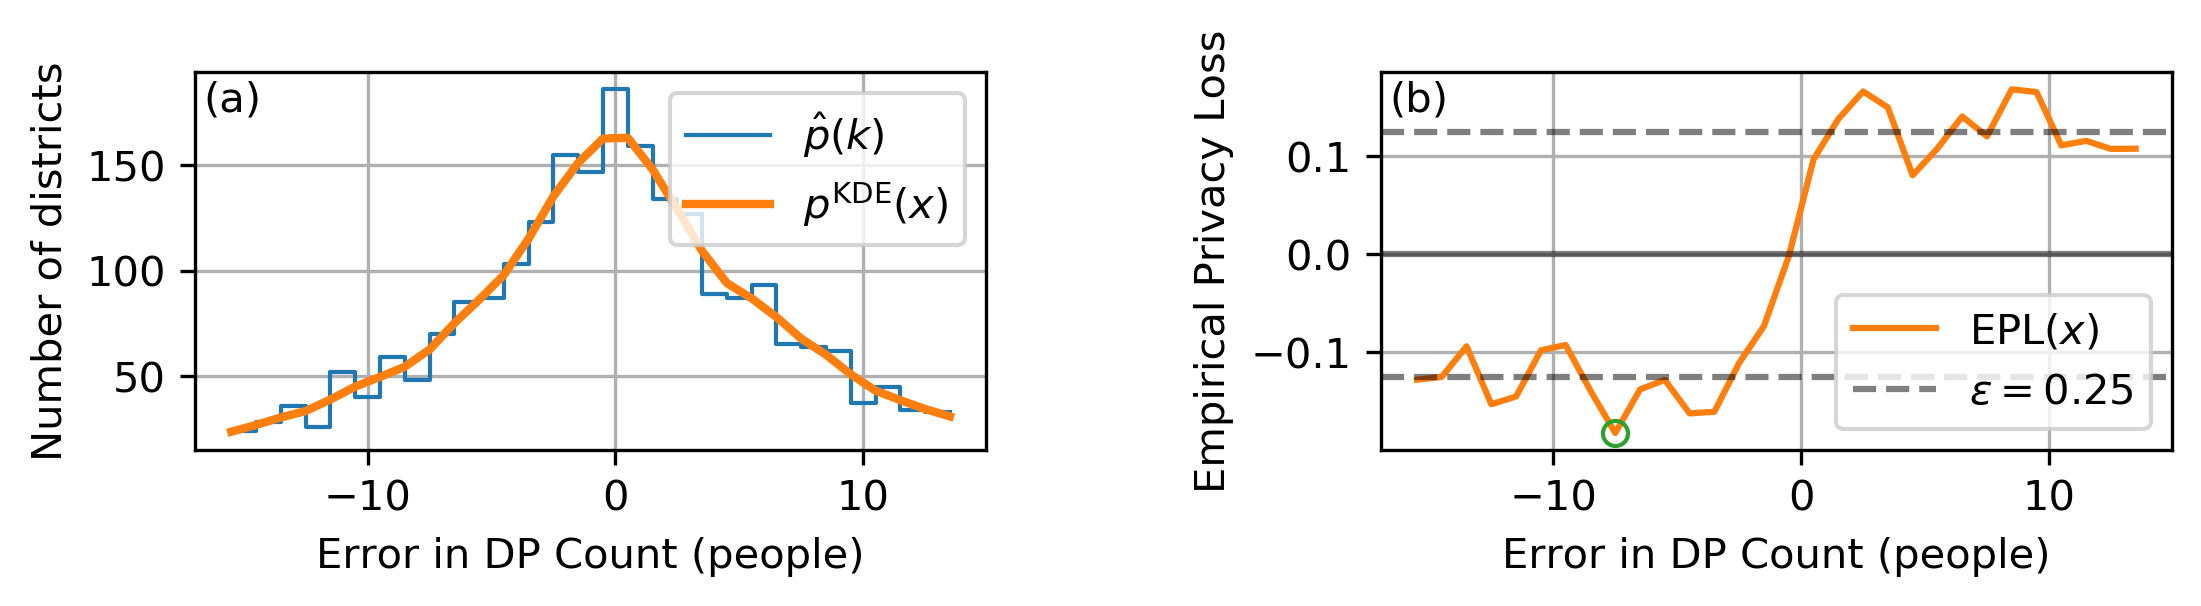

In [9]:
def my_plot(df_epl):
    fig, ax = plt.subplots(ncols=2, figsize=(8.5, 2), dpi=300)
    
    ax[0].plot(df_epl['hist'], linewidth=1, linestyle='-', label='$\\hat{p}(k)$', drawstyle='steps')
    ax[0].plot(df_epl['smooth_hist'], linewidth=2, linestyle='-', label='$p^{\\mathrm{KDE}}(x)$')
    
    ax[0].set_ylabel('Number of districts')
    ax[0].set_xlabel('Error in DP Count (people)')
    ax[0].grid()
    ax[0].text(.01, .98, '(a)', transform=ax[0].transAxes, ha='left', va='top')
    ax[0].legend(loc='upper right')

    ax[1].plot(df_epl['smooth_epl'], linestyle='-', color='C1', label='$\\mathrm{EPL}(x)$')
    xx = np.absolute(df_epl.smooth_epl).idxmax()
    yy = np.absolute(df_epl.smooth_epl).max()
    ax[1].plot([xx], [-yy], 'o', color='none', mec='C2', mew=1)
    
    ax[1].set_ylabel('Empirical Privacy Loss')
    ax[1].set_xlabel('Error in DP Count (people)')
    ax[1].axhline(0, color='k', alpha=.5)
    ax[1].axhline(epsilon/2, color='k', linestyle='--', alpha=.5, label=f'$\\epsilon = {epsilon}$')
    ax[1].axhline(-epsilon/2, color='k', linestyle='--', alpha=.5)
    ax[1].grid()
    ax[1].text(.01, .98, '(b)', transform=ax[1].transAxes, ha='left', va='top')
    ax[1].legend(loc='lower right')
    
    plt.subplots_adjust(wspace=.5, bottom=.25)

my_plot(df_epl)
plt.savefig('fig_SA2_hist_epl.png')

In [10]:
np.absolute(df_epl.smooth_epl).max()

0.18231889317777084

In [11]:
2*np.percentile(np.absolute(df_epl.smooth_epl), 50)

0.2531263972795559

We validated our approach by repeating this calculation for a range of epsilon values, and performed a one-way sensitivity analysis to see if changing the bandwidth or limits for maximization would substantially change the ability of the method to recover an EPL value matching epsilon for the Geometric Mechanism. 

In [12]:
def validate_epl(gdp_epsilon, bandwidth, est_range_percentile, est_range_multiplier):
    cnt_gdpc = dp_2020_census.model.GDPC(epsilon/2, cnt_orig)
    error = cnt_gdpc - cnt_orig
    df_epl = dp_2020_census.model.empirical_privacy_loss(
        error, bandwidth=0.1, est_range_percentile=95, est_range_multiplier=1.0)
#     return 2*np.percentile(np.absolute(df_epl.smooth_epl), 50)
    return np.absolute(df_epl.smooth_epl).max()

validate_epl(gdp_epsilon=0.25, bandwidth=.1, est_range_percentile=95, est_range_multiplier=1)

0.21834089747369775

In [13]:
n_reps = 10

In [14]:
np.random.seed(123435) # set seed for reproducibility

results = []

for epsilon in [.001, .005, .01, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]:
    for replicate in range(n_reps):
        epl = validate_epl(gdp_epsilon=epsilon, bandwidth=.1, est_range_percentile=95, est_range_multiplier=1)
        results.append(dict(epsilon=epsilon, epl=epl, replicate=replicate))
    
results = pd.DataFrame(results)

/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:78: RuntimeWarning: divide by zero encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:78: RuntimeWarning: invalid value encountered in true_divide
  ratio = f_empirical[:-1] / f_empirical[1:]
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:82: RuntimeWarning: divide by zero encountered in log
  df['epl_hist'] = np.log(ratio)
/ihme/homes/abie/projects/2019/dp_2020_census/dp_2020_census/model.py:85: RuntimeWarning: invalid value encountered in true_divide
  df['epl_cusum'] = np.log(ccusum[1:] / ccusum[:-1])


In [15]:
epl_by_epsilon = results.groupby('epsilon').epl.describe(percentiles=[.025, .975])
np.round(epl_by_epsilon.filter(['mean', '2.5%', '97.5%']), 4)

,mean,2.5%,97.5%
epsilon,,,
0.001,0.0010,0.0008,0.0011
0.005,0.0045,0.0037,0.0053
0.010,0.0092,0.0082,0.0112
0.050,0.0477,0.0388,0.0561
0.100,0.1015,0.0823,0.1368
...,...,...,...
0.300,0.2823,0.2292,0.3909
0.350,0.3326,0.2769,0.4564
0.400,0.3407,0.2869,0.4290


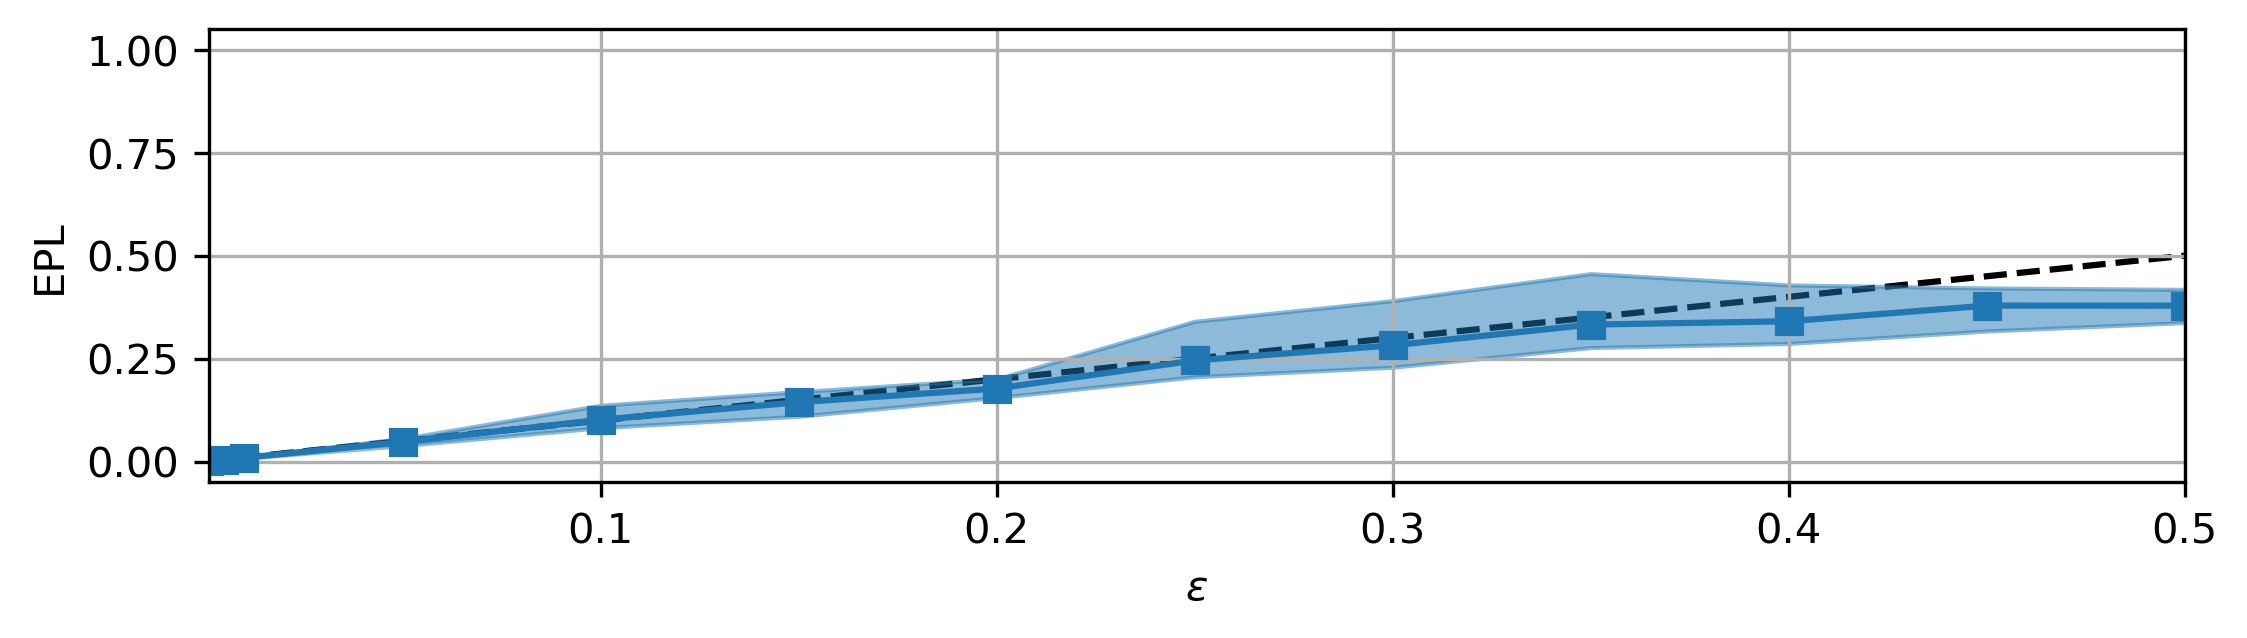

In [16]:
fig, ax = plt.subplots(ncols=1, figsize=(8.5, 2), dpi=300)

epl_by_epsilon['mean'].plot(marker='s', ax=ax)
plt.plot([0,1], [0,1], 'k--', zorder=-1)

plt.fill_between(epl_by_epsilon.index, epl_by_epsilon['2.5%'],  epl_by_epsilon['97.5%'], color='C0', alpha=.5)
plt.grid()
plt.xlabel('$\\epsilon$')
plt.ylabel('EPL');

In [17]:
np.random.seed(123435) # set seed for reproducibility

results = []

epsilon = .25

for bandwidth in [.001, .005, .01, .05, .1, .5, 1, 5]:
    for replicate in range(n_reps):
        epl = validate_epl(gdp_epsilon=epsilon, bandwidth=bandwidth,
                           est_range_percentile=95, est_range_multiplier=1)
        results.append(dict(epsilon=epsilon, epl=epl, bandwidth=bandwidth, replicate=replicate))
    
results = pd.DataFrame(results)

In [18]:
epl_by_bandwidth = results.groupby('bandwidth').epl.describe(percentiles=[.025, .975])
np.round(epl_by_bandwidth.filter(['mean', '2.5%', '97.5%']), 4)

,mean,2.5%,97.5%
bandwidth,,,
0.001,0.2392,0.2012,0.2840
0.005,0.2188,0.1888,0.2577
0.010,0.2380,0.2025,0.2733
0.050,0.2409,0.2002,0.2788
0.100,0.2432,0.1889,0.3144
0.500,0.2343,0.1917,0.2681
1.000,0.2233,0.1878,0.2690
5.000,0.2456,0.2059,0.3407


In [19]:
np.random.seed(123435) # set seed for reproducibility

results = []

epsilon = .25
bandwidth = .1

for pct_range in [75, 85, 95, 99, 99.9]:
    for replicate in range(n_reps):
        epl = validate_epl(gdp_epsilon=epsilon, bandwidth=bandwidth,
                           est_range_percentile=pct_range, est_range_multiplier=1)
        results.append(dict(epsilon=epsilon, epl=epl, bandwidth=bandwidth,
                            pct_range=pct_range, replicate=replicate))
    
results = pd.DataFrame(results)

In [20]:
epl_by_pct_range = results.groupby('pct_range').epl.describe(percentiles=[.025, .975])
np.round(epl_by_pct_range.filter(['mean', '2.5%', '97.5%']), 4)

,mean,2.5%,97.5%
pct_range,,,
75.0,0.2392,0.2012,0.2840
85.0,0.2188,0.1888,0.2577
95.0,0.2380,0.2025,0.2733
99.0,0.2409,0.2002,0.2788
99.9,0.2432,0.1889,0.3144


In [21]:
np.random.seed(123435) # set seed for reproducibility

results = []

epsilon = .25
bandwidth = .1
pct_range = 95

for range_multiplier in [.5, 1, 1.5, 2]:
    for replicate in range(n_reps):
        epl = validate_epl(gdp_epsilon=epsilon, bandwidth=bandwidth,
                           est_range_percentile=pct_range, est_range_multiplier=range_multiplier)
        results.append(dict(epsilon=epsilon, epl=epl, bandwidth=bandwidth,
                            pct_range=pct_range, range_multiplier=range_multiplier, replicate=replicate))
    
results = pd.DataFrame(results)

In [22]:
epl_by_range_multiplier = results.groupby('range_multiplier').epl.describe(percentiles=[.025, .975])
np.round(epl_by_range_multiplier.filter(['mean', '2.5%', '97.5%']), 4)

,mean,2.5%,97.5%
range_multiplier,,,
0.5,0.2392,0.2012,0.2840
1.0,0.2188,0.1888,0.2577
1.5,0.2380,0.2025,0.2733
2.0,0.2409,0.2002,0.2788
